## Importing basic libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Creating the dataframe

In the following lines we are imporing data and creating pandas dataframe in order to compute the required values.

The Milan Dataframe contains the pollution and wheather variables with the exception of wind speed (km/h). 

We have three different datasets that we need to merge by the variable "Date", however this variable is written in different formats in all of them. That’s why, for every data set we are manually creating a second variable "date" that matches with every one of them.
Notices that before creating the matching date variable, we sorted the data set by the original date to be sure that data were matching.

In [2]:
milan = pd.read_csv("03_015_2017-2020 - Milan.csv")
milan = milan.sort_values(["YYYY", "MM", "DD"])
dates2 = pd.date_range("2017/01/01", periods = 1461, freq = "D")
milan["date"] = dates2
milan = pd.DataFrame(milan)
milan.tail(5)

YYYY  MM  DD  COM   GP   A[km2]    TG    TN    TX     HU  ...  \
1456  2020  12  27  133  535  1575.32  0.63 -3.06  4.40  57.55  ...   
1457  2020  12  28  133  535  1575.32  1.21  0.35  1.50  80.55  ...   
1458  2020  12  29  133  535  1575.32 -0.94 -4.23  2.10  77.71  ...   
1459  2020  12  30  133  535  1575.32  2.87  0.30  5.47  78.53  ...   
1460  2020  12  31  133  535  1575.32 -0.64 -5.68  4.23  67.22  ...   

      SO2_Median  SO2_StDev  SO2_Max SO2_COMx SO2_Min SO2_COMn SO2_TS_GP  \
1456        3.13       0.58     6.22     1883    1.78     1833         0   
1457        2.77       0.58     6.11     1883    1.24     1833         0   
1458         ---        ---      ---      ---     ---      ---       ---   
1459         ---        ---      ---      ---     ---      ---       ---   
1460         ---        ---      ---      ---     ---      ---       ---   

     SO2_TS_A[km2] SO2_TS_A[%]       date  
1456             0           0 2020-12-27  
1457             0           0 2020-12-28  
1458           ---         --- 2020-12-29  
1459           ---         --- 2020-12-30  
1460           ---         --- 2020-12-31  

[5 rows x 124 columns]

Now we are simply importing the information for the variable wind speed. Through the statement windspeed.rename(), we are also changing the name of the variable that contains wind speed information just to be more clear.

In [3]:
windspeed = pd.read_csv("windspeed.csv")
windpseed = windspeed.sort_values("Date")
del windspeed["Date"]
dates = pd.date_range("2020/01/01", periods = 366, freq = "D")
windspeed["date"] = dates
windspeed = windspeed.rename(columns = {"V. MEDIA VENTO" : "windspeed_Av"})
wind = pd.DataFrame(windspeed)
wind.head()

windspeed_Av       date
0           4.1 2020-01-01
1           4.5 2020-01-02
2           3.2 2020-01-03
3           6.3 2020-01-04
4           4.0 2020-01-05

Last we have the data set about Covid-19 cases. Since we only need cases for 2020 we are slicing only for that year.

In [4]:
cases = pd.read_csv("covid_cases.txt")
#cases.info()

In [5]:
casesmilan = cases.loc[cases["denominazione_provincia"] == "Milano"]
tot_cases = casesmilan.loc[casesmilan["data"] < "2021-01-01T17:00:00"]
tot_cases = pd.DataFrame(tot_cases)
tot_cases = tot_cases.sort_values("data")

The original set only contained the cumulative cases variable, so we are computing a differentiation on it( with the df.diff() statement) to obtain a new variable which is daily cases.

In [6]:
tot_cases['daily'] = tot_cases['totale_casi'].diff().fillna(tot_cases['totale_casi'])
tot_cases["daily"].head()

49      0.0
177     8.0
305     0.0
433     7.0
561    14.0
Name: daily, dtype: float64

In [7]:
tot_cases = tot_cases[["denominazione_provincia", "totale_casi", "daily"]]
dates = pd.date_range("2020/02/24", periods = 312, freq = "D")
tot_cases["date"] = dates

In this step we merged the three data sets through the command df1.merge(df2, on = "date", how = "left"). The key input "left" is used to avoid deleting the observation for the first part of 2020 of weather information. <br>
We had also a problem with the way that missing values were specified in "milan" dataframe, that is why we used the command df.replace('---', np.nan) to replace "---" with numpy's nan.

In [8]:
df = milan.merge(tot_cases, on='date', how = "left")
df = df.merge(wind, on='date', how = "left")
df = df.set_index("date")
df = df[df["YYYY"] == 2020]
df = df.replace('---', np.nan)

According to the article, we divided the dataframe in different bimesters and then we also created the first quarter of 2020 dataframe. <br>
A fundamental step was to change the type of the values from "object" to "float" in order to compute descriptive statistics.

In [9]:
df = df[["TG", "TX","HU", "AQI_1_Av", "AQI_1_Max", "AQI_2_Av", "PM2.5_Av", "PM10_Av", "PM10_Max", "totale_casi", "daily", "windspeed_Av"]]
df = df.astype(float)
df_ja_ap = df.loc["2020-01-01" : "2020-04-30"]
df_ja_fe = df.loc["2020-01-01" : "2020-02-29"]
df_ma_ap = df.loc["2020-03-01" : "2020-04-30"]

### Air Quality Table

To explain the meaning of the index's value we use the following table. As you can see the lower the Air Quality Index the better is the air quality, while the higher the index the worse the quality.

In [10]:
Table1_AQI = pd.DataFrame(["Very Good","Good","Satisfactory","Sufficiently","Poor","Very Poor"],
index=pd.Index(["<10","10 - 20","20 - 30","30 - 50","50 -80","80>"]),
columns=pd.MultiIndex.from_product([["Class"]], names = ["AQI"]))
Table1_AQI

AQI             Class
<10         Very Good
10 - 20          Good
20 - 30  Satisfactory
30 - 50  Sufficiently
50 -80           Poor
80>         Very Poor

## Descriptive statistics

In these lines of code for each variable we computed the mean, the standard deviation and range.

In [11]:
meanJF_AQI = df_ja_fe.loc[:"2020-02-29"].mean()["AQI_1_Av"]
meanJF_AQI = round(meanJF_AQI, 2)
stdJF_AQI = df_ja_fe.loc[:"2020-02-29"].std()["AQI_1_Av"]
stdJF_AQI = round(stdJF_AQI, 2)
meanJF_AQI = str(meanJF_AQI)+ ' ± ' + str(stdJF_AQI)
minJF_AQI = df_ja_fe.loc[:"2020-02-29"].min()["AQI_1_Av"]
maxJF_AQI = df_ja_fe.loc[:"2020-02-29"].max()["AQI_1_Av"]
rangeJF_AQI = str(minJF_AQI)+ ' - ' + str(maxJF_AQI)

In [12]:
meanJF_AQI2 = df_ja_fe.loc[:"2020-02-29"].mean()["AQI_2_Av"]
meanJF_AQI2 = round(meanJF_AQI2, 2)
stdJF_AQI2 = df_ja_fe.loc[:"2020-02-29"].std()["AQI_2_Av"]
stdJF_AQI2 = round(stdJF_AQI2, 2)
meanJF_AQI2 = str(meanJF_AQI2)+ ' ± ' + str(stdJF_AQI2)
minJF_AQI2 = df_ja_fe.loc[:"2020-02-29"].min()["AQI_2_Av"]
maxJF_AQI2 = df_ja_fe.loc[:"2020-02-29"].max()["AQI_2_Av"]
rangeJF_AQI2 = str(minJF_AQI2)+ ' - ' + str(maxJF_AQI2)


In [13]:
meanJF_PM2 = df_ja_fe.loc[:"2020-02-29"].mean()["PM2.5_Av"]
meanJF_PM2 = round(meanJF_PM2, 2)
stdJF_PM2 = df_ja_fe.loc[:"2020-02-29"].std()["PM2.5_Av"]
stdJF_PM2 = round(stdJF_PM2, 2)
meanJF_PM2 = str(meanJF_PM2)+ ' ± ' + str(stdJF_PM2)
minJF_PM2 = df_ja_fe.loc[:"2020-02-29"].min()["PM2.5_Av"]
maxJF_PM2 = df_ja_fe.loc[:"2020-02-29"].max()["PM2.5_Av"]
rangeJF_PM2 = str(minJF_PM2)+ ' - ' + str(maxJF_PM2)

In [14]:
meanJF_PM10 = df_ja_fe.loc[:"2020-02-29"].mean()["PM10_Av"]
meanJF_PM10 = round(meanJF_PM10, 2)
stdJF_PM10 = df_ja_fe.loc[:"2020-02-29"].std()["PM10_Av"]
stdJF_PM10 = round(stdJF_PM10, 2)
meanJF_PM10 = str(meanJF_PM10)+ ' ± ' + str(stdJF_PM10)
minJF_PM10 = df_ja_fe.loc[:"2020-02-29"].min()["PM10_Av"]
maxJF_PM10 = df_ja_fe.loc[:"2020-02-29"].max()["PM10_Av"]
rangeJF_PM10 = str(minJF_PM10)+ ' - ' + str(maxJF_PM10)

In [15]:
meanJF_PM10M = df_ja_fe.loc[:"2020-02-29"].mean()["PM10_Max"]
meanJF_PM10M = round(meanJF_PM10M, 2)
stdJF_PM10M = df_ja_fe.loc[:"2020-02-29"].std()["PM10_Max"]
stdJF_PM10M = round(stdJF_PM10M, 2)
meanJF_PM10M = str(meanJF_PM10M)+ ' ± ' + str(stdJF_PM10M)
minJF_PM10M = df_ja_fe.loc[:"2020-02-29"].min()["PM10_Max"]
maxJF_PM10M = df_ja_fe.loc[:"2020-02-29"].max()["PM10_Max"]
rangeJF_PM10M = str(minJF_PM10M)+ ' - ' + str(maxJF_PM10M)

In [16]:
meanMA_AQI = df_ma_ap.loc["2020-03-01":"2020-04-30"].mean()["AQI_1_Av"]
meanMA_AQI = round(meanMA_AQI, 2)
stdMA_AQI = df_ma_ap.loc["2020-03-01":"2020-04-30"].std()["AQI_1_Av"]
stdMA_AQI = round(stdMA_AQI, 2)
meanMA_AQI = str(meanMA_AQI)+ ' ± ' + str(stdMA_AQI)
minMA_AQI = df_ma_ap.loc["2020-03-01":"2020-04-30"].min()["AQI_1_Av"]
maxMA_AQI = df_ma_ap.loc["2020-03-01":"2020-04-30"].max()["AQI_1_Av"]
rangeMA_AQI = str(minMA_AQI)+ ' - ' + str(maxMA_AQI)

In [17]:
meanMA_AQI2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].mean()["AQI_2_Av"]
meanMA_AQI2 = round(meanMA_AQI2, 2)
stdMA_AQI2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].std()["AQI_2_Av"]
stdMA_AQI2 = round(stdMA_AQI2, 2)
meanMA_AQI2 = str(meanMA_AQI2)+ ' ± ' + str(stdMA_AQI2)
minMA_AQI2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].min()["AQI_2_Av"]
maxMA_AQI2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].max()["AQI_2_Av"]
rangeMA_AQI2 = str(minMA_AQI2)+ ' - ' + str(maxMA_AQI2)

In [18]:
meanMA_PM2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].mean()["PM2.5_Av"]
meanMA_PM2 = round(meanMA_PM2, 2)
stdMA_PM2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].std()["PM2.5_Av"]
stdMA_PM2 = round(stdMA_PM2, 2)
meanMA_PM2 = str(meanMA_PM2)+ ' ± ' + str(stdMA_PM2)
minMA_PM2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].min()["PM2.5_Av"]
maxMA_PM2 = df_ma_ap.loc["2020-03-01":"2020-04-30"].max()["PM2.5_Av"]
rangeMA_PM2 = str(minMA_PM2)+ ' - ' + str(maxMA_PM2)

In [19]:
meanMA_PM10 = df_ma_ap.loc["2020-03-01":"2020-04-30"].mean()["PM10_Av"]
meanMA_PM10 = round(meanMA_PM10, 2)
stdMA_PM10 = df_ma_ap.loc["2020-03-01":"2020-04-30"].std()["PM10_Av"]
stdMA_PM10 = round(stdMA_PM10, 2)
meanMA_PM10 = str(meanMA_PM10)+ ' ± ' + str(stdMA_PM10)
minMA_PM10 = df_ma_ap.loc["2020-03-01":"2020-04-30"].min()["PM10_Av"]
maxMA_PM10 = df_ma_ap.loc["2020-03-01":"2020-04-30"].max()["PM10_Av"]
rangeMA_PM10 = str(minMA_PM10)+ ' - ' + str(maxMA_PM10)

In [20]:
meanMA_PM10M = df_ma_ap.loc["2020-03-01":"2020-04-30"].mean()["PM10_Max"]
meanMA_PM10M = round(meanMA_PM10M, 2)
stdMA_PM10M = df_ma_ap.loc["2020-03-01":"2020-04-30"].std()["PM10_Max"]
stdMA_PM10M = round(stdMA_PM10M, 2)
meanMA_PM10M = str(meanMA_PM10M)+ ' ± ' + str(stdMA_PM10M)
minMA_PM10M = df_ma_ap.loc["2020-03-01":"2020-04-30"].min()["PM10_Max"]
maxMA_PM10M = df_ma_ap.loc["2020-03-01":"2020-04-30"].max()["PM10_Max"]
rangeMA_PM10M = str(minMA_PM10M)+ ' - ' + str(maxMA_PM10M)

Next we have a summary table for the descriptive statistics computed above. It is remarkable that for the March-April bimester both the Air Quality indexes and PM surface levels were lower (in average) than the first bimester; this means that the Air Quality was better in the second bimester. <br>
This result may be explained by the effect of lockdown that occured in the second bimester <br>
We do not observe substantial change in the variability.

In [21]:
Table2 = pd.DataFrame(
{
("January–February 2020", "Mean value:"):
{"Daily average particulate matter PM2.5 (μg/m3)": meanJF_PM2,
"Daily average particulate matter PM10 (μg/m3)": meanJF_PM10,
"Daily maxima particulate matter PM10 (μg/m3)": meanJF_PM10M,
"Daily Air Quality Index": meanJF_AQI,
"Daily Air Quality Index 2": meanJF_AQI2},

("January–February 2020", "Range"):
{"Daily average particulate matter PM2.5 (μg/m3)": rangeJF_PM2,
"Daily average particulate matter PM10 (μg/m3)": rangeJF_PM10,
"Daily maxima particulate matter PM10 (μg/m3)": rangeJF_PM10M,
"Daily Air Quality Index":rangeJF_AQI,
"Daily Air Quality Index 2":rangeJF_AQI2},

("March–April 2020", "Mean value:"):
{"Daily average particulate matter PM2.5 (μg/m3)":meanMA_PM2,
"Daily average particulate matter PM10 (μg/m3)": meanMA_PM10,
"Daily maxima particulate matter PM10 (μg/m3)": meanMA_PM10M,
"Daily Air Quality Index":meanMA_AQI,
"Daily Air Quality Index 2":meanMA_AQI2},

("March–April 2020", "Range"):
{"Daily average particulate matter PM2.5 (μg/m3)": rangeMA_PM2,
"Daily average particulate matter PM10 (μg/m3)": rangeMA_PM10,
"Daily maxima particulate matter PM10 (μg/m3)": rangeMA_PM10M,
"Daily Air Quality Index":rangeMA_AQI,
"Daily Air Quality Index 2":rangeMA_AQI2}
}
)
Table2

January–February 2020  \
                                                         Mean value:   
Daily average particulate matter PM2.5 (μg/m3)          40.33 ± 15.2   
Daily average particulate matter PM10 (μg/m3)          45.41 ± 16.28   
Daily maxima particulate matter PM10 (μg/m3)           51.15 ± 17.36   
Daily Air Quality Index                                 41.74 ± 16.0   
Daily Air Quality Index 2                               48.7 ± 14.97   

                                                               \
                                                        Range   
Daily average particulate matter PM2.5 (μg/m3)   10.29 - 71.9   
Daily average particulate matter PM10 (μg/m3)    13.94 - 75.9   
Daily maxima particulate matter PM10 (μg/m3)    14.88 - 80.84   
Daily Air Quality Index                         14.89 - 78.34   
Daily Air Quality Index 2                        25.25 - 79.2   

                                               March–April 2020                 
                                                    Mean value:          Range  
Daily average particulate matter PM2.5 (μg/m3)    29.85 ± 13.65   13.2 - 62.13  
Daily average particulate matter PM10 (μg/m3)     35.05 ± 15.35   15.4 - 69.43  
Daily maxima particulate matter PM10 (μg/m3)      41.61 ± 16.24  17.15 - 80.71  
Daily Air Quality Index                           35.23 ± 12.71  16.05 - 69.35  
Daily Air Quality Index 2                         43.69 ± 12.46  24.65 - 72.75

## Analysis of correlations

Now we are computing, through the df.corr() statement, the Pearson correlation coefficients. Correlations are between the variables total cases and both Air Quality Index (AQI) and then between total cases and PM levels. We now consider the first quarter of the year.

In [22]:
cor_cas_PM2 = round(df_ja_ap.corr()["totale_casi"]["PM2.5_Av"],2)
cor_cas_PM10 = round(df_ja_ap.corr()["totale_casi"]["PM10_Av"],2)
cor_cas_PM10M = round(df_ja_ap.corr()["totale_casi"]["PM10_Max"],2)
cor_cas_AQI = round(df_ja_ap.corr()["totale_casi"]["AQI_1_Av"],2)
cor_cas_AQI2 = round(df_ja_ap.corr()["totale_casi"]["AQI_2_Av"],2)


Same process for the correlations with Covid-19 daily new cases.

In [23]:
cor_day_PM2 = round(df_ja_ap.corr()["daily"]["PM2.5_Av"],2)
cor_day_PM10 = round(df_ja_ap.corr()["daily"]["PM10_Av"],2)
cor_day_PM10M = round(df_ja_ap.corr()["daily"]["PM10_Max"],2)
cor_day_AQI = round(df_ja_ap.corr()["daily"]["AQI_1_Av"],2)
cor_day_AQI2 = round(df_ja_ap.corr()["daily"]["AQI_2_Av"],2)

In the next table we present all the indicators we have computed above. We can see that in general correlations for the variable total cases are weak. On the other hand (for daily new cases variable) correlations are stronger, in particular between the daily cases and AQI (both the indexes). Since the first estimation of the AQI is slightly more correlated and its average values are more faithful to the article, we will use AQI1 in further analysis.


In particular AQI and daily cases have positive correlation, this means that in average when the AQI index is higher (so quality is worse) we have more cases. The same applies for the PM levels, in average the more particular matter in the air, the more daily Covid-19 cases.

In [24]:
Table3 = pd.DataFrame(
{
("Time period: 1 January–30 April 2020, Pearson correlation values", "Daily average PM2.5 (μg/m3)"):
{"Total cases": cor_cas_PM2 ,
"Daily New cases": cor_day_PM2,
},



("Time period: 1 January–30 April 2020, Pearson correlation values", " Daily average PM10 (μg/m3)"):
{"Total cases": cor_cas_PM10,
"Daily New cases": cor_day_PM10,
},



("Time period: 1 January–30 April 2020, Pearson correlation values", "Daily maxima PM10 (μg/m3)"):
{"Total cases":cor_cas_PM10M,
"Daily New cases": cor_day_PM10M,
},



("Time period: 1 January–30 April 2020, Pearson correlation values", "Air Quality Index"):
{"Total cases": cor_cas_AQI,
"Daily New cases": cor_day_AQI,
},
 
("Time period: 1 January–30 April 2020, Pearson correlation values", "Air Quality Index 2"):
{"Total cases": cor_cas_AQI2,
"Daily New cases": cor_day_AQI2,
}
}
)
Table3.index.name="COVID-19 number cases"
Table3

Time period: 1 January–30 April 2020, Pearson correlation values  \
                                                           Daily average PM2.5 (μg/m3)   
COVID-19 number cases                                                                    
Total cases                                                        -0.20                 
Daily New cases                                                     0.27                 

                                                                             \
                       Daily average PM10 (μg/m3) Daily maxima PM10 (μg/m3)   
COVID-19 number cases                                                         
Total cases                                 -0.14                     -0.13   
Daily New cases                              0.30                      0.30   

                                                             
                      Air Quality Index Air Quality Index 2  
COVID-19 number cases                                        
Total cases                        0.10                0.14  
Daily New cases                    0.41                0.39

We then repeat the same process for computing correlations between variables concerning air quality and weather.

In [25]:
cor_t_PM2 = round(df_ja_ap.corr()["TG"]["PM2.5_Av"],2)
cor_H_PM2 = round(df_ja_ap.corr()["HU"]["PM2.5_Av"],2)
cor_w_PM2 = round(df_ja_ap.corr()["windspeed_Av"]["PM2.5_Av"],2)

In [26]:
cor_t_PM10 = round(df_ja_ap.corr()["TG"]["PM10_Av"],2)
cor_H_PM10 = round(df_ja_ap.corr()["HU"]["PM10_Av"],2)
cor_w_PM10 = round(df_ja_ap.corr()["windspeed_Av"]["PM10_Av"],2)


In [27]:
cor_t_PM10M = round(df_ja_ap.corr()["TG"]["PM10_Max"],2)
cor_H_PM10M = round(df_ja_ap.corr()["HU"]["PM10_Max"],2)
cor_w_PM10M = round(df_ja_ap.corr()["windspeed_Av"]["PM10_Max"],2)

In [28]:
cor_t_AQI = round(df_ja_ap.corr()["TG"]["AQI_1_Av"],2)
cor_H_AQI = round(df_ja_ap.corr()["HU"]["AQI_1_Av"],2)
cor_w_AQI = round(df_ja_ap.corr()["windspeed_Av"]["AQI_1_Av"],2)

The following table shows the Pearson coefficients.  We can observe that the average temperature and the wind speed variables are negatively correlated with all the pollution variables. This means that warm and windy days have in average a higher air quality. On the other hand relative humidity has positive correlation, so it is a factor that is related to worse air quality.

In [29]:
Table4 = pd.DataFrame(
{
("Time period: 1 January–30 April 2020, Pearson correlation values", "Daily average PM2.5 (μg/m3)"):
{"Air temperature (T) (°C)": cor_t_PM2,
"Relative humidity (RH) ( %)":cor_H_PM2,
"Wind speed intensity (km/h)": cor_w_PM2},



("Time period: 1 January–30 April 2020, Pearson correlation values", " Daily average PM10 (μg/m3)"):
{"Air temperature (T) (°C)": cor_t_PM10,
"Relative humidity (RH) ( %)": cor_H_PM10,
"Wind speed intensity (km/h)": cor_w_PM10},



("Time period: 1 January–30 April 2020, Pearson correlation values", "Daily maxima PM10 (μg/m3)"):
{"Air temperature (T) (°C)": cor_t_PM10M,
"Relative humidity (RH) ( %)": cor_H_PM10M,
"Wind speed intensity (km/h)": cor_w_PM10M},



("Time period: 1 January–30 April 2020, Pearson correlation values", "Air Quality Index"):
{"Air temperature (T) (°C)": cor_t_AQI,
"Relative humidity (RH) ( %)": cor_H_AQI,
"Wind speed intensity (km/h)": cor_w_AQI}
}
)
Table4.index.name="Daily average climate variable"
Table4

Time period: 1 January–30 April 2020, Pearson correlation values  \
                                                                    Daily average PM2.5 (μg/m3)   
Daily average climate variable                                                                    
Air temperature (T) (°C)                                                    -0.34                 
Relative humidity (RH) ( %)                                                  0.36                 
Wind speed intensity (km/h)                                                 -0.41                 

                                                            \
                                Daily average PM10 (μg/m3)   
Daily average climate variable                               
Air temperature (T) (°C)                             -0.30   
Relative humidity (RH) ( %)                           0.38   
Wind speed intensity (km/h)                          -0.38   

                                                                            
                               Daily maxima PM10 (μg/m3) Air Quality Index  
Daily average climate variable                                              
Air temperature (T) (°C)                           -0.25             -0.22  
Relative humidity (RH) ( %)                         0.38              0.29  
Wind speed intensity (km/h)                        -0.37             -0.47

We are able now to use the weather factors to detect possible explanatory variables for the covid-19 daily and total cases.

In [30]:
cor_cas_H = round(df_ja_ap.corr()["totale_casi"]["HU"],2)
cor_day_H = round(df_ja_ap.corr()["daily"]["HU"],2)

In [31]:
cor_day_t = round(df_ja_ap.corr()["daily"]["TG"],2)
cor_cas_t = round(df_ja_ap.corr()["totale_casi"]["TG"],2)


In [32]:
cor_day_w = round(df_ja_ap.corr()["daily"]["windspeed_Av"],2)
cor_cas_w = round(df_ja_ap.corr()["totale_casi"]["windspeed_Av"],2)


From the table does not emerge any strong correlation beside the one between total cases variable and average temperature. Nevertheless, this is a sporious correlation. In the first quarter of the year, temperatures tends to increase, also the number of cases since it is a cumulative variable.

In [33]:
Table5 = pd.DataFrame(
{

("Time period: 1 January–30 April 2020", "Air temp. T (°C)"):
{"Total cases": cor_cas_t,
"Daily New cases": cor_day_t},

("Time period: 1 January–30 April 2020", "Relative humidity RH(%)"):
{"Total cases":cor_cas_H,
"Daily New cases": cor_day_H},

("Time period: 1 January–30 April 2020", "Wind speed (km/h)"):
{"Total cases": cor_cas_w,
"Daily New cases": cor_day_w}
}
)

Table5.index.name="COVID-19 number cases"
Table5

Time period: 1 January–30 April 2020  \
                                          Air temp. T (°C)   
COVID-19 number cases                                        
Total cases                                           0.72   
Daily New cases                                       0.18   

                                                                 
                      Relative humidity RH(%) Wind speed (km/h)  
COVID-19 number cases                                            
Total cases                              0.10              0.04  
Daily New cases                          0.08             -0.21

## Graphic visualizations

In the next plot is shown the time series of the pollution variables. What we can see is that they all have a similar nature. Since they have the same scale we are able to plot the variables in the same y and x axis.

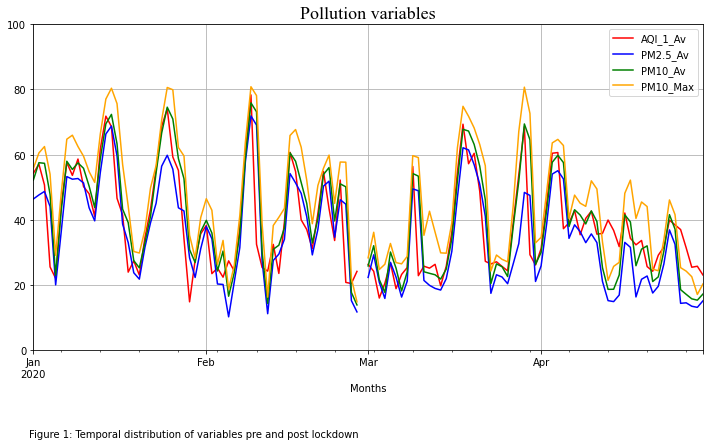

In [34]:
df_ja_ap["AQI_1_Av"].plot(c = "red", figsize = (12,6))
df_ja_ap["PM2.5_Av"].plot(c = "blue")
df_ja_ap["PM10_Av"].plot(c = "green")
df_ja_ap["PM10_Max"].plot(c = "orange")
plt.ylim(0, 100)
plt.figtext(0.12, -0.075, "Figure 1: Temporal distribution of variables pre and post lockdown" , 
            fontsize=10)
plt.title("Pollution variables", fontsize = 18, **{'fontname':'Times New Roman'})
plt.xlabel('Months')
plt.legend(loc='best')
plt.grid()
plt.show()


In order to better understand the behaviour of these variables we have created a plot where you can see their own tendency over time.

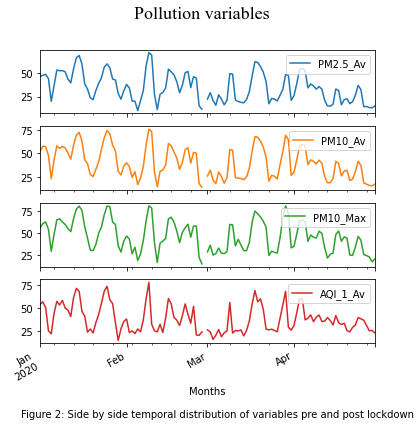

In [35]:
ax = df_ja_ap[["PM2.5_Av","PM10_Av", "PM10_Max", "AQI_1_Av"]].plot(subplots=True, figsize=(6, 6)); plt.legend(loc='best')
#subplot is to generate the division between plots
plt.xlabel('Months')
plt.suptitle("Pollution variables", fontsize = 18, **{'fontname':'Times New Roman'})
plt.figtext(0.08, 0.03, "Figure 2: Side by side temporal distribution of variables pre and post lockdown" , 
            fontsize=10)
plt.legend(loc='best')
plt.show()

To have a better visualization about their tendency, we can observe the plot of PM levels and daily new cases.

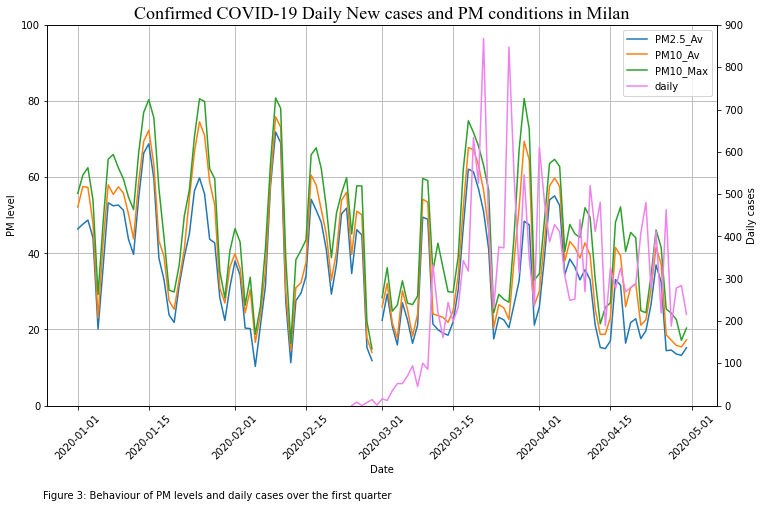

In [36]:
fig = plt.figure() 
ax = fig.add_subplot(111) #size of the plot
fig1 = ax.plot(df_ja_ap["PM2.5_Av"], label = 'PM2.5_Av')
fig2 = ax.plot(df_ja_ap["PM10_Av"], label = 'PM10_Av')
fig3 = ax.plot(df_ja_ap["PM10_Max"], label = 'PM10_Max')
ax2 = ax.twinx() #create another axes
fig4 = ax2.plot(df_ja_ap["daily"], label = 'daily', c = "violet")

# added these three lines
figs = fig1+fig2+fig3+fig4 #merge every label in a single legend
labs = [l.get_label() for l in figs] #set legend labels
ax.legend(figs, labs, loc=0) #create legend
ax.grid()
ax.set_xlabel("Date") #x-axis name
ax2.set_ylim(0, 900) #fix second y-axis length
ax.set_ylim(0,100) #fix first y-axis length
ax2.set_ylabel("Daily cases")
ax.set_ylabel("PM level")
plt.setp(ax.get_xticklabels(), rotation = 45)

plt.title("Confirmed COVID-19 Daily New cases and PM conditions in Milan", fontsize = 18, **{'fontname':'Times New Roman'})
plt.figtext(0.12, -0.06, "Figure 3: Behaviour of PM levels and daily cases over the first quarter" , 
            fontsize=10)

fig.set_figheight(7)
fig.set_figwidth(12)
plt.show()

We already discussed that total cases and daily average temperatures have a spurious correlation; in the following graphic we are able to see their always incresing tendency over the first quarter of the year. <br>
As you can see in the first two subplots we only have information starting from February.

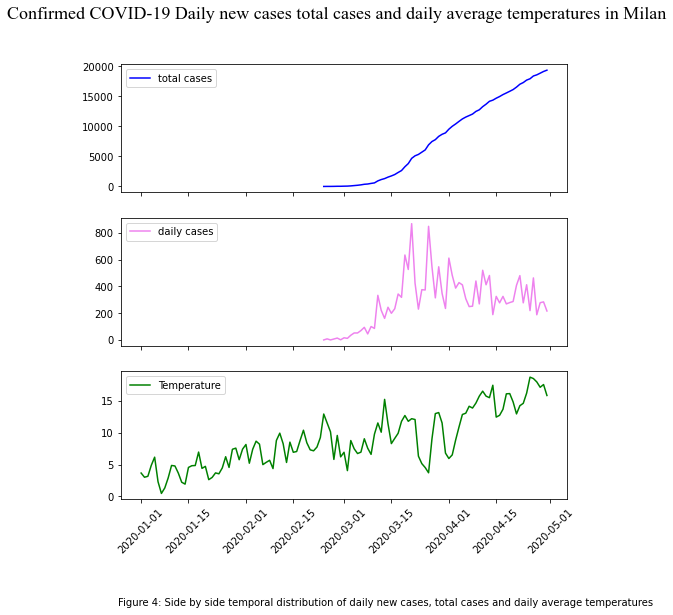

In [37]:
import matplotlib.pyplot as plt

labels = ["total cases", "daily cases", "Temperature"]
colors = ["blue","violet","green"]

fig,axs = plt.subplots(3, sharex=True, sharey=False, figsize=(8, 8))

axs[0].plot(df_ja_ap["totale_casi"], color = colors[0], label = labels[0])
axs[0].legend(loc="upper left")

axs[1].plot(df_ja_ap["daily"], color = colors[1], label = labels[1])
axs[1].legend(loc="upper left")

axs[2].plot(df_ja_ap["TG"], color = colors[2], label = labels[2])
axs[2].legend(loc="upper left")

plt.suptitle("Confirmed COVID-19 Daily new cases total cases and daily average temperatures in Milan", fontsize = 18, **{'fontname':'Times New Roman'})
plt.figtext(0.12, -0.06, "Figure 4: Side by side temporal distribution of daily new cases, total cases and daily average temperatures" , 
            fontsize=10)


plt.setp(axs[2].get_xticklabels(), rotation = 45)
plt.show()

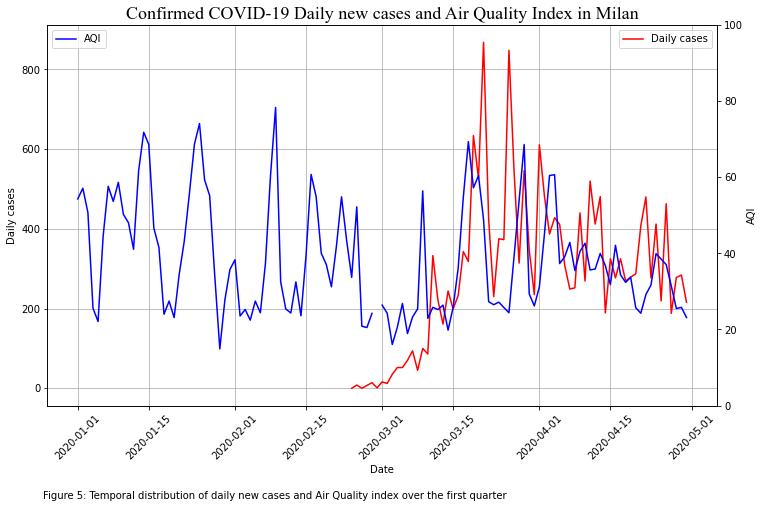

In [38]:
import matplotlib.pyplot as plt

labels = ["Daily cases", "AQI"]
colors = ["red","blue"]

fig,ax = plt.subplots(1, sharex=True, sharey=False, figsize=(8, 8))

ax1 = ax.twinx() #create another axes
ax.plot(df_ja_ap["daily"] , color = colors[0], label = labels[0])
ax1.plot(df_ja_ap["AQI_1_Av"] , color = colors[1], label = labels[1])

ax.legend(loc="upper right")
ax1.legend(loc = "upper left")
ax1.set_ylim(0, 100) #fix third y_axis length
ax1.set_ylabel("AQI") #x-axis name
ax.set_ylabel("Daily cases") #x-axis name
ax.grid()
ax.set_xlabel("Date")

plt.title("Confirmed COVID-19 Daily new cases and Air Quality Index in Milan", fontsize = 18, **{'fontname':'Times New Roman'})
plt.figtext(0.12, -0.06, "Figure 5: Temporal distribution of daily new cases and Air Quality index over the first quarter" , 
            fontsize=10)


fig.set_figheight(7)
fig.set_figwidth(12)

plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()